# Problem 1, reading in excel data, munging it into dataframes, and plotting long term annual mean precip by water year with geopandas over the Jalama watershed

In [1]:
import pandas as pd
import geopandas as gpd
import os
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np

# didn't use this function because of a problem with Pillow reading  some byte format
def add_basemap(ax, zoom, url='http://a.tile.stamen.com/terrain/{z}/{x}/{y}.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

def get_single_sheet(excel_obj, sheet_id, use_n_cols=8, skip_n_rows=9):
    """
    
    Reads in precip gauge data from sb_county. Defaults for cols and rows 
    used for reading in the daily data.
    
    """
    return excel_obj.parse(sheet_name=sheet_id, usecols=list(range(0,use_n_cols)), skiprows=list(range(0,skip_n_rows)))


This reads in a big excel file with multiple sheets, then applies a function to seperate the sheets so that we can make a dataframe with annual averages for the water year

In [2]:
stations_df = pd.read_excel("Precipitation_Data.xlsx")

xlsx = pd.ExcelFile("Precipitation_Data.xlsx")


sheets = []
for sheet in xlsx.sheet_names:
    if sheet != 'Stations':
        sheets.append(get_single_sheet(xlsx, sheet, 8, 9))

In [3]:
def longterm_mean_annual_precip(i):
    """Groups a sheet df by water year, takes the 
    sum of daily rainfall and then takes the mean 
    of the annual sums"""
    
    if 'water year' not in sheets[i]:
        sheets[i].rename(columns={'wy':"water year", 'dailyrain':"daily rain"}, inplace=True)
    return sheets[i].groupby('water year')['daily rain'].sum().mean()

longterm_means = []
for i, sheet in enumerate(sheets):
    longterm_means.append(longterm_mean_annual_precip(i))

Here we make the df from the list of long term annual means. We then associate this with the spatial data in the first sheet. This works because both lists (longterm_means and the stations_df Lon and Lat columns) are each ordered the same and of the same length

In [4]:
long_means_df = pd.DataFrame({'Long Term Annual Means':longterm_means})

long_means_df['Coordinates'] = list(zip(stations_df.Lon,stations_df.Lat))

long_means_df['Coordinates']=long_means_df['Coordinates'].apply(Point)

gdf_longterm_means = gpd.GeoDataFrame(long_means_df, geometry='Coordinates')
gdf_longterm_means.crs = {'init': 'epsg:4326'}

jalama_ws = gpd.read_file('JalamaWatershed.shp')
santa_ynez_ws = gpd.read_file('santa_ynez_watershed.shp')

santa_ynez_ws = santa_ynez_ws.to_crs(jalama_ws.crs)

Using zoom level 9, this will download 6 tiles


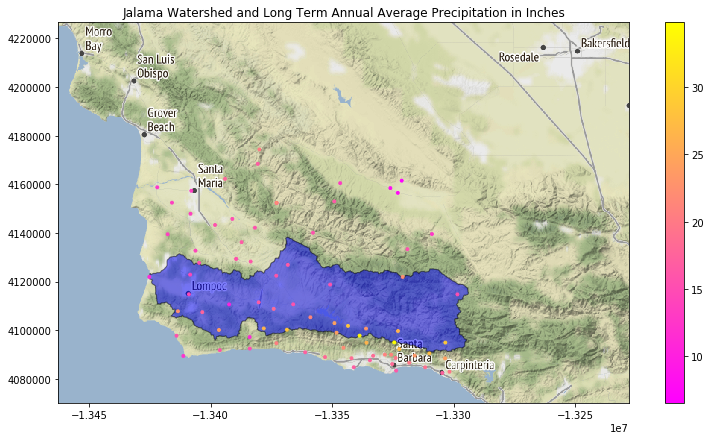

In [5]:
# this grabs a basemap tile from Stamen using contextily
w,s,e,n = gdf_longterm_means.total_bounds
_ = ctx.howmany(w, s, e, n, 9, ll=True)
img, ext = ctx.bounds2img(w, s, e, n, 9, ll=True)

f, ax = plt.subplots(1, figsize=(13,7))
ax.imshow(img, extent=ext)

santa_ynez_ws.to_crs(epsg=3857).plot(ax = ax, color = 'blue', edgecolor='black', alpha=0.5)
gdf_longterm_means.to_crs(epsg=3857).plot(ax = ax, marker = 'H', markersize = 10, column="Long Term Annual Means", cmap="spring" , legend = True)
plt.title("Jalama Watershed and Long Term Annual Average Precipitation in Inches")
plt.savefig("Figure1_Jalama_and_LongTerm_Precip.png")

# Problem 2, regression plot 

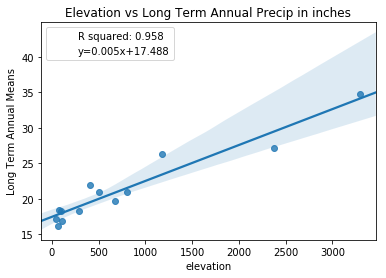

In [6]:
import seaborn as sns
from scipy import stats
from matplotlib.patches import Rectangle

gdf_longterm_means['In SB/Goleta Region?'] = stations_df['SB/Goleta Region']
gdf_longterm_means['elevation'] = stations_df['Elevation (ft above sea level)']

gdf_sb_precip = gdf_longterm_means[gdf_longterm_means['In SB/Goleta Region?'] == 'Y']
df = pd.DataFrame(gdf_sb_precip)

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(list(df['elevation']), list(df['Long Term Annual Means']))

ax = sns.regplot(df['elevation'], df['Long Term Annual Means'], line_kws={'label':"y={0:.5f}x+{1:.3f}".format(slope,intercept)})
plt.title('Elevation vs Long Term Annual Precip in inches')
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
ax.legend([extra, extra], (("R squared: {0:.3f}".format(r_value)), "y={0:.3f}x+{1:.3f}".format(slope,intercept)), loc=2)
plt.savefig("Figure2LongTerm_Precip_reg.png")

Problem 3: Results paragraph

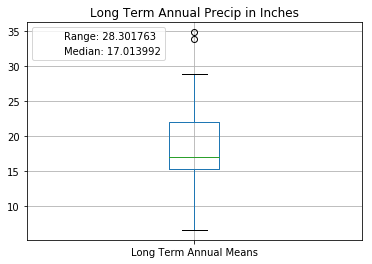

In [7]:
ax = long_means_df.boxplot('Long Term Annual Means')
plt.title("Long Term Annual Precip in Inches")
ax.legend([extra, extra], (("Range: {0:3f}".format(max(longterm_means)-min(longterm_means))), "Median: {0:3f}".format(np.median(longterm_means))), loc=2)

Could write about 100 more words talking about spatial variation ...

The above plot show the range, median, and box plot of long term annual means. Rainfall clearly varies quite a bit, with a range that is considerably larger than the median. About 96% of this variation is explained by elevation alone, indicating that over multi decadal time scales, the long term averages primarily vary due to the regional topography. Looking at the map of precipitation amount over all 80 of our rain gauges, it is clear that the highest long term annual averages are observed around the Santa Ynez mountains at higher elevations, the closer you get to Santa Barbara. This indicates that there is a rain shadow effect that is contributing to high precipitation at higher elevations. The lowlands north of the Santa Ynez mountains, both within and outside of Jalama watershed, are dry (most are below the median) because of a consistently dry climate consisting of hot northerly air. This is also true at the western edge of the Santa Ynez mountains, where 5 gauges show precipitation values below ~15 inches. It looks like this could be due to a rain shadow effect as well, because a couple precipitation gauges north of the mountains show higher precipitation values (shown in orange) which indicate amounts above the median.

Problem 4. Total Catchement Area of Jalama Watershed with units

In [8]:
jalama_ws.AreaSqKm

0    63.592358
Name: AreaSqKm, dtype: float64

Problem 5 Create Thiessen polygons for santa ynez watershed, make a map, create table detailing fraction of watershed that intersects each monitoring station's thiessen polygon, calculate estimate of mean annual precipitation in watershed

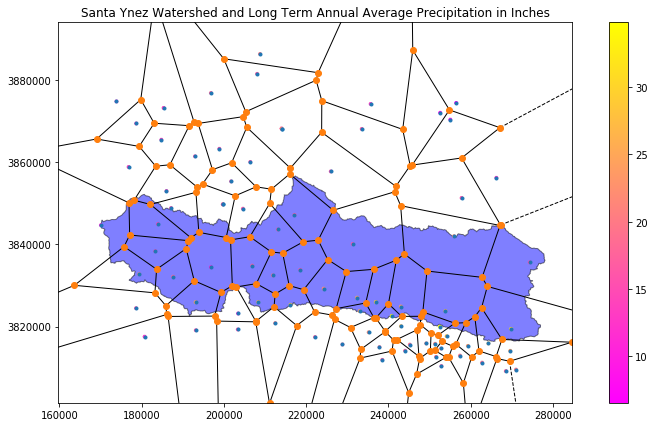

In [9]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Voronoi.html
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.voronoi_plot_2d.html

from scipy.spatial import Voronoi, voronoi_plot_2d

gdf_means_utm = gdf_longterm_means.to_crs(epsg=32611)

point_coords = [np.array((geom.xy[0][0], geom.xy[1][0])) for geom in gdf_means_utm.centroid]

vor = Voronoi(point_coords)

# # this grabs a basemap tile from Stamen using contextily
# w,s,e,n = gdf_longterm_means.total_bounds
# _ = ctx.howmany(w, s, e, n, 9, ll=True)
# img, ext = ctx.bounds2img(w, s, e, n, 9, ll=True)

f, ax = plt.subplots(1, figsize=(13,7))
# ax.imshow(img, extent=ext)
f = voronoi_plot_2d(vor, ax = ax)
santa_ynez_ws.to_crs(epsg=32611).plot(ax = ax, color = 'blue', edgecolor='black', alpha=0.5)
gdf_longterm_means.to_crs(epsg=32611).plot(ax = ax, marker = 'H', markersize = 10, column="Long Term Annual Means", cmap="spring" , legend = True)
plt.title("Santa Ynez Watershed and Long Term Annual Average Precipitation in Inches")
plt.savefig("Figure3_SantaYnez_and_Thiessen.png")
plt.show()

testing this new package that wraps the above scipy voronoi functions but integrates with shapely https://github.com/WZBSocialScienceCenter/geovoronoi

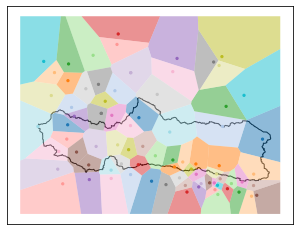

In [12]:
import shapely.geometry as shpgeo
import matplotlib.pyplot as plt
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords

area_shape = santa_ynez_ws.to_crs(epsg=3395).iloc[0].geometry
gdf_means = gdf_longterm_means.to_crs(epsg=3395)
buffered_box = shpgeo.box(*gdf_means.total_bounds).buffer(10000).bounds
buffered_box = shpgeo.box(*buffered_box)

point_coords = np.array([np.array((geom.xy[0][0], geom.xy[1][0])) for geom in gdf_means.centroid])
poly_shapes, pts, poly_to_pt_assignments = voronoi_regions_from_coords(point_coords, buffered_box)

fig, ax = subplot_for_map()
plot_voronoi_polys_with_points_in_area(ax, area_shape, poly_shapes, point_coords, poly_to_pt_assignments)
plt.show()

These are the fractional areas of the voronoi diagram that intersect the watershed. We need the whole polygons that are partially contained by the watershed so that we can associate the rain gauge values with them.

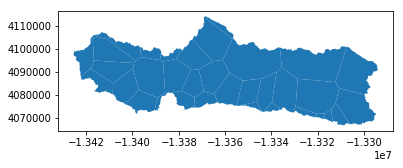

In [18]:
voronoi_gdf = gpd.GeoDataFrame().set_geometry(poly_shapes)
voronoi_gdf.crs = {'init' : 'epsg:3395'}

# to test multiple intersections, geodfs need to be same length or need to use shapely geometry
vor_intersections = voronoi_gdf.intersection(santa_ynez_ws.to_crs(epsg=3395).iloc[0]['geometry'])

vor_intersections.plot()

Plot of total voronoi polygons that intersect with watershed

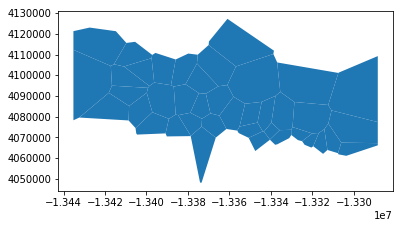

In [28]:
# only area contained within watershed
vor_areas = vor_intersections.area[vor_intersections.area > 0]
vor_intersections = vor_intersections[vor_intersections.area > 0]
whole_vor_intersections = voronoi_gdf[voronoi_gdf.index.isin(vor_intersections.index)]
whole_vor_intersections.plot()

In [33]:
gdf_longterm_means = gdf_longterm_means.to_crs(epsg = 3395)
joined_vors = gpd.sjoin(whole_vor_intersections, gdf_longterm_means)

/home/rave/anaconda3/envs/earth-analytics-python/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


In [36]:
vor_areas.count()
joined_vors.count #discrepency here, need to get area values in the table

40

In [31]:
joined_vors['area_intersects'] = vor_areas
sy_ws_mercator = santa_ynez_ws.to_crs(epsg=3395)
joined_vors['area_fraction'] = joined_vors['area_intersects'].apply(lambda x:x/sy_ws_mercator.area[0])

/home/rave/anaconda3/envs/earth-analytics-python/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


Table of fractional area for each station polygon that intersects the watershed

In [171]:
intersects_gdf = gpd.GeoDataFrame(geometry=vor_intersections)
intersects_gdf['area_intersects'] = vor_areas


/home/rave/anaconda3/envs/earth-analytics-python/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


,geometry,area_intersects,area_fraction,index_right,Long Term Annual Means,In SB/Goleta Region?,elevation
0,POLYGON ((-13312377.36233872 4085676.031319599...,2.227689e+08,0.065106,29,15.240000,NaN,4600
1,POLYGON ((-13307533.06116003 4100932.052966269...,3.170455e+08,0.092659,26,22.175113,NaN,6360
2,POLYGON ((-13312377.36233872 4085676.031319599...,2.268513e+08,0.066299,12,26.210202,NaN,1500
3,POLYGON ((-13310765.09923218 4083045.676783971...,1.734253e+08,0.050685,10,28.852174,NaN,2230
19,POLYGON ((-13336372.59765268 4100455.528164802...,3.135827e+08,0.091647,25,15.591504,NaN,1690
20,POLYGON ((-13369053.51688027 4113807.047470042...,1.754271e+08,0.051270,69,16.431875,NaN,1180
22,POLYGON ((-13335477.10306896 4091956.983916321...,1.524668e+08,0.044560,21,23.167500,NaN,1029
30,POLYGON ((-13403427.70811932 4076266.991434426...,8.369709e+07,0.024461,64,23.792405,NaN,640
31,POLYGON ((-13365360.79834421 4094689.088233143...,1.261318e+08,0.036863,19,15.690000,NaN,600
33,POLYGON ((-13374098.74374503 4104026.966649202...,1.109792e+08,0.032435,68,15.992609,NaN,1000


Problem 6 300 words on results

Problem 7 Do Thiessen polygons again for Jalama, with 2 figures